In [12]:
# Notebook: Notebook1BronzeNewtoSilverProcessing (with EDA)

from pyspark.sql.functions import col, explode_outer, from_json, count, desc
from pyspark.sql.types import StructType, StructField, StringType, ArrayType
import matplotlib.pyplot as plt
from datetime import datetime
# ------------------------------
# 1️⃣ Define paths
# ------------------------------
storage_account = "datalakerwe"
container = "rweantibody"

bronze_new_path = "abfss://rwedatalakestorage@datalakerwe.dfs.core.windows.net/bronze/new/"
bronze_archive_base = "abfss://rwedatalakestorage@datalakerwe.dfs.core.windows.net/bronze/archive/"
silver_processing_path = "abfss://rwedatalakestorage@datalakerwe.dfs.core.windows.net/silver/processing/"

StatementMeta(openfda, 0, 13, Finished, Available, Finished)

Top-level fields:

meta → contains metadata about the dataset (disclaimer, last_updated, results summary, terms).

results → an array of records, each representing a safety report.

Nested arrays and structs:

results contains element structs, each with fields like companynumb, patient, primarysource, sender, etc.

patient itself has nested arrays like drug (with element structs containing drug details), reaction, and summary.

drug contains further nested structs, including activesubstance and openfda (which itself contains arrays like brand_name, manufacturer_name, etc.).

Other nested fields:

primarysource, receiver, reportduplicate, and sender are structs with additional metadata.

Dates and flags like serious, seriousnessdeath, seriousnesshospitalization are strings at the results.element level.

In [ ]:
# ------------------------------
# 2️⃣ Read JSON from Bronze.New (multiline JSON)
# ------------------------------
df_raw = spark.read.option("multiline", True).json(bronze_new_path)

print("✅ Loaded raw JSON")
df_raw.printSchema()

Now the DataFrame will have this structure:

safetyreportid → string

receivedate → string

serious → string

patient → struct, containing:

drug → array of structs

patientonsetage, patientonsetageunit, patientsex, patientweight

reaction → array of structs

summary → struct

In [ ]:
# ------------------------------
# 3️⃣ Extract just the reports from 'results'
# ------------------------------
df_bronze = (
    df_raw
    .withColumn("report", explode_outer("results"))
    .select(
        col("report.safetyreportid"),
        col("report.receivedate"),
        col("report.serious"),
        col("report.patient")
    )
)

print(f"✅ Extracted {df_bronze.count()} reports")
df_bronze.printSchema()
df_bronze.show(5, truncate=False)

StatementMeta(openfda, 0, 16, Finished, Available, Finished)

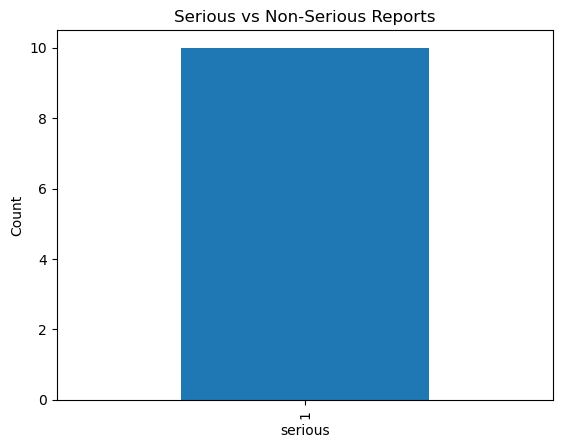

In [15]:
# ------------------------------
# 4️⃣ EDA - Quick Exploration
# ------------------------------
serious_counts = (
    df_bronze.groupBy("serious")
    .count()
    .orderBy(desc("count"))
    .toPandas()
)

serious_counts.plot(kind="bar", x="serious", y="count", legend=False, title="Serious vs Non-Serious Reports")
plt.ylabel("Count")
plt.show()

Now each row will represent a single drug–reaction pair for a report, with these columns:

safetyreportid → the report ID

receivedate → date of the report

serious → serious flag (1/0)

medicinalproduct → name of the drug

drugcharacterization → type of drug (e.g., suspect/concomitant)

reactionmeddrapt → reported reaction

reactionoutcome → outcome of the reaction

Key observations:

Exploding both drug and reaction arrays multiplied the rows, which is why you now have 224 records from 10 reports.

This structure is perfect for analysis, aggregation, or joining with other tables (e.g., FDA drug metadata).

In [16]:
# ------------------------------
# 5️⃣ Flatten nested patient structure
# ------------------------------
drug_schema = ArrayType(
    StructType([
        StructField("medicinalproduct", StringType(), True),
        StructField("drugcharacterization", StringType(), True)
    ])
)

reaction_schema = ArrayType(
    StructType([
        StructField("reactionmeddrapt", StringType(), True),
        StructField("reactionoutcome", StringType(), True)
    ])
)
df_flat = (
    df_bronze
    .withColumn("drug", explode_outer(col("patient.drug")))
    .withColumn("reaction", explode_outer(col("patient.reaction")))
    .select(
        col("safetyreportid"),
        col("receivedate"),
        col("serious"),
        col("drug.medicinalproduct").alias("medicinalproduct"),
        col("drug.drugcharacterization").alias("drugcharacterization"),
        col("reaction.reactionmeddrapt").alias("reactionmeddrapt"),
        col("reaction.reactionoutcome").alias("reactionoutcome")
    )
)

print(f"✅ Flattened into {df_flat.count()} records")
df_flat.show(5, truncate=False)

StatementMeta(openfda, 0, 17, Finished, Available, Finished)

✅ Flattened into 224 records
+--------------+-----------+-------+--------------------------+--------------------+----------------+---------------+
|safetyreportid|receivedate|serious|medicinalproduct          |drugcharacterization|reactionmeddrapt|reactionoutcome|
+--------------+-----------+-------+--------------------------+--------------------+----------------+---------------+
|10408858      |20140826   |1      |PACLITAXEL.               |1                   |Hypokalaemia    |1              |
|10408858      |20140826   |1      |DIFFU K                   |2                   |Hypokalaemia    |1              |
|10408858      |20140826   |1      |RO 5479599 (ANTI-HER3 MAB)|1                   |Hypokalaemia    |1              |
|10408858      |20140826   |1      |PERTUZUMAB                |1                   |Hypokalaemia    |1              |
|10408858      |20140826   |1      |PERTUZUMAB                |1                   |Hypokalaemia    |1              |
+--------------+-----------

StatementMeta(openfda, 0, 20, Finished, Available, Finished)

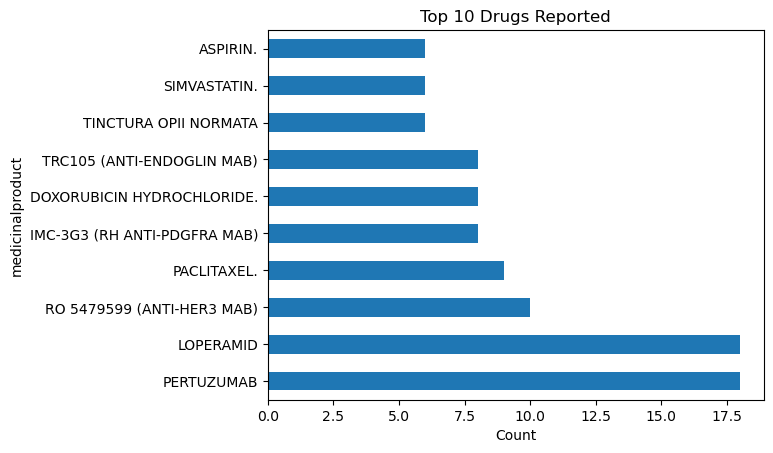

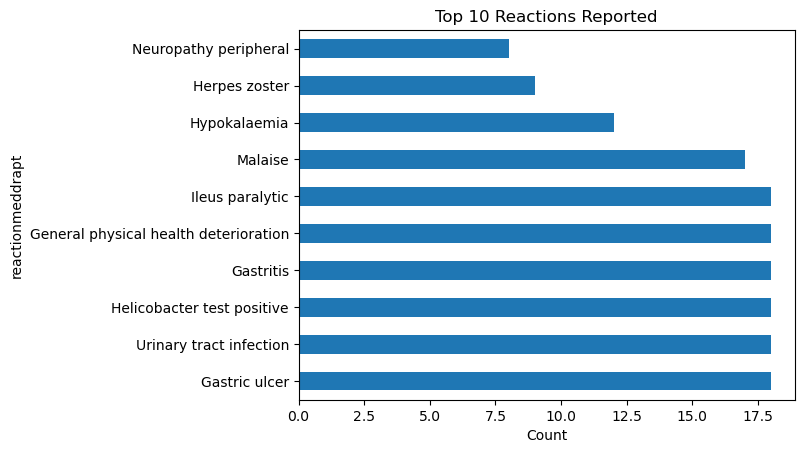

In [19]:
# ------------------------------
# 6️⃣ More EDA on Flattened Data
# ------------------------------

# Top 10 drugs
top_drugs = (
    df_flat.groupBy("medicinalproduct")
    .count()
    .orderBy(desc("count"))
    .limit(10)
    .toPandas()
)

top_drugs.plot(kind="barh", x="medicinalproduct", y="count", legend=False, title="Top 10 Drugs Reported")
plt.xlabel("Count")
plt.show()

# Top 10 reactions
top_reactions = (
    df_flat.groupBy("reactionmeddrapt")
    .count()
    .orderBy(desc("count"))
    .limit(10)
    .toPandas()
)

top_reactions.plot(kind="barh", x="reactionmeddrapt", y="count", legend=False, title="Top 10 Reactions Reported")
plt.xlabel("Count")
plt.show()

In [23]:
# ------------------------------
# 5️⃣ Write to Silver with timestamped name
# ------------------------------
from datetime import datetime

# Use the already defined Silver processing path
timestamp = datetime.utcnow().strftime("%Y-%m-%dT%H-%M-%S")
silver_output_path = f"{silver_processing_path}openfda_antibody_silver_{timestamp}.parquet"

# Write DataFrame to Parquet in Silver layer
df_flat.write.mode("overwrite").parquet(silver_output_path)

print(f"✅ Written Parquet to Silver layer: {silver_output_path}")

StatementMeta(openfda, 0, 24, Finished, Available, Finished)

✅ Written Parquet to Silver layer: abfss://rwedatalakestorage@datalakerwe.dfs.core.windows.net/silver/processing/openfda_antibody_silver_2025-08-28T10-02-06.parquet


# Release Spark pool

In [ ]:
mssparkutils.session.stop()